Library imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import ceil
from sklearn.model_selection import GroupKFold

Loads the datacube

In [2]:
data = pd.read_csv("/data/2021_Table04_Datacube.csv", encoding='latin-1')
data.head()

,"ï»¿""H3_Address""",H3_Resolution,H3_Geometry,Longitude_EPSG4326,Latitude_EPSG4326,Continent_Majority,Continent_Minority,Country_Majority,Country_Minority,Province_Majority,...,Litmod_Density_Asthenosphere,Litmod_Density_Crust,Litmod_Density_Lithosphere,Crust1_Type,Crust1_CrustalThickness,Crust1_SedimentThickness,Training_MVT_Deposit,Training_MVT_Occurrence,Training_CD_Deposit,Training_CD_Occurrence
0,8712e579bffffff,7,"POLYGON ((-115.0314 54.5077, -115.0393 54.4961...",-115.018142,54.497221,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260254,3337.300049,island arc,-38.450497,2991.459961,Absent,Absent,Absent,Absent
1,8712e579affffff,7,"POLYGON ((-115.0658 54.51706, -115.0737 54.505...",-115.052542,54.506590,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260010,3337.300293,island arc,-38.430000,3000.000244,Absent,Absent,Absent,Absent
2,8712e56b4ffffff,7,"POLYGON ((-115.0604 54.49501, -115.0682 54.483...",-115.047107,54.484541,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.259766,3337.300049,island arc,-38.430000,3000.000000,Absent,Absent,Absent,Absent
3,8712e56b5ffffff,7,"POLYGON ((-115.026 54.48564, -115.0338 54.4740...",-115.012729,54.475169,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260010,3337.300049,island arc,-38.591599,2932.666504,Absent,Absent,Absent,Absent
4,8712e56a6ffffff,7,"POLYGON ((-114.997 54.49832, -115.0049 54.4867...",-114.983753,54.487840,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260010,3337.300049,island arc,-39.815273,2422.801758,Absent,Absent,Absent,Absent


In [3]:
# modifies the labeLs to booleans
data["Training_MVT_Deposit"] = data["Training_MVT_Deposit"].apply(lambda x: True if x == "Present" else False)
data["Training_MVT_Occurrence"] = data["Training_MVT_Occurrence"].apply(lambda x: True if x == "Present" else False)
data["Training_CD_Deposit"] = data["Training_CD_Deposit"].apply(lambda x: True if x == "Present" else False)
data["Training_CD_Occurrence"] = data["Training_CD_Occurrence"].apply(lambda x: True if x == "Present" else False)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5164970 entries, 0 to 5164969
Data columns (total 97 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   ï»¿"H3_Address"                                 object 
 1   H3_Resolution                                   int64  
 2   H3_Geometry                                     object 
 3   Longitude_EPSG4326                              float64
 4   Latitude_EPSG4326                               float64
 5   Continent_Majority                              object 
 6   Continent_Minority                              object 
 7   Country_Majority                                object 
 8   Country_Minority                                object 
 9   Province_Majority                               object 
 10  Province_Minority                               object 
 11  Terrane_Majority                                object 
 12  Terrane_Minority            

Selects the data /labels used for MVT WOE baseline

In [4]:
baseline_cols = [
    "H3_Geometry",                                      # Polygon coordinates
    "Seismic_LAB_Priestley",                            # Depth to LAB
    "Seismic_Moho",                                     # Depth to Moho
    "Gravity_GOCE_ShapeIndex",                          # Sattelite Gravity
    "Gravity_Bouguer",                                  # Gravity Bouger
    "Gravity_Bouguer_HGM",                              # Gravity HGM
    "Gravity_Bouguer_UpCont30km_HGM",                   # Gravity upward cont'd HGM
    "Gravity_Bouguer_HGM_Worms_Proximity",              # Gravity worms
    "Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity",   # Gravity upward cont'd worms
    "Magnetic_HGM",                                     # Magnetic HGM
    "Magnetic_LongWavelength_HGM",                      # Magnetic long-wavelength HGM
    "Magnetic_HGM_Worms_Proximity",                     # Magnetic worms
    "Magnetic_LongWavelength_HGM_Worms_Proximity",      # Magnetic long-wavelength worms
    "Training_MVT_Deposit",
    "Training_MVT_Occurrence",
]
mvt_data = data[baseline_cols]

Original paper sets neighbors of polygons with "Training_MVT_Deposit=Present" and "Training_MVT_Occurrence=Present" to "MVT_Deposit=Present" (note: now Deposit means - Deposit, Occurrence, or their neighbor). The following function finds all the neighbors.

In [5]:
def neighbor_deposits(df):
    # merging Deposit and Occurrence
    df['MVT_Deposit'] = df.apply(lambda row: True if True in [row['Training_MVT_Deposit'], row['Training_MVT_Occurrence']] else False, axis=1)

    #  converting H3_Geometry POLYGON(()) to list of 6 coordinates [(* *), (* *), (* *), (* *), (* *), (* *)]
    df['H3_Geometry2'] = df['H3_Geometry'].apply(lambda x: x[10:-2].split(', ')[:-1])

    # filtering df with MVT_Deposit present
    df_present = df[df['MVT_Deposit']==True] # for MVT there are 2027 rows

    # record all vertices of MVT_Deposit Present polygons
    present_coordinates = [] # -> for MVT 9915 vertices
    for coordinates in df_present['H3_Geometry2']:
        for coordinate in coordinates:
            if coordinate not in present_coordinates:
                present_coordinates.append(coordinate)
    present_coordinates = set(present_coordinates) # converting to set()
                
    # checking if any of 6 vertices of polygon are in present_coordinates
    # if YES then it's a neighbor or itself polygon
    df['MVT_Deposit_wNeighbors'] = df.apply(lambda x: True if (present_coordinates & set(x['H3_Geometry2'])) else False, axis=1)
    df = df.drop(columns=['H3_Geometry2'])
    return df

In [6]:
mvt_data = neighbor_deposits(mvt_data)

/var/folders/cp/r_wzy_f57v5_mx1pr4h_7gtxkv1blz/T/ipykernel_66960/3920331978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MVT_Deposit'] = df.apply(lambda row: True if True in [row['Training_MVT_Deposit'], row['Training_MVT_Occurrence']] else False, axis=1)
/var/folders/cp/r_wzy_f57v5_mx1pr4h_7gtxkv1blz/T/ipykernel_66960/3920331978.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['H3_Geometry2'] = df['H3_Geometry'].apply(lambda x: x[10:-2].split(', ')[:-1])
/var/folders/cp/r_wzy_f57v5_mx1pr4h

In [7]:
print(mvt_data['MVT_Deposit'].value_counts())
print(mvt_data['MVT_Deposit_wNeighbors'].value_counts())

MVT_Deposit
False    5162943
True        2027
Name: count, dtype: int64
MVT_Deposit_wNeighbors
False    5155482
True        9488
Name: count, dtype: int64


In [8]:
mvt_labels = mvt_data['MVT_Deposit_wNeighbors']
mvt_data = mvt_data.drop(columns=['H3_Geometry', 'Training_MVT_Deposit', 'Training_MVT_Occurrence', 'MVT_Deposit', 'MVT_Deposit_wNeighbors'])
baseline_cols = baseline_cols[1:-2]

Clearly the dataset has MANY outliers, as reported in the paper

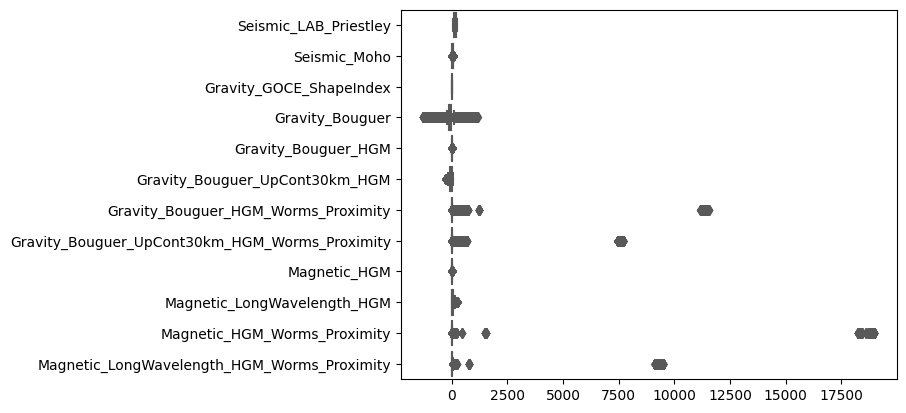

In [9]:
ax = sns.boxplot(data=mvt_data, orient="h", palette="Set2")

In [10]:
def tukey_remove_outliers(df, multiplier=1.5, replacement_percentile=0.05):
    for col in df.columns:
        # get the IQR
        Q1 = df.loc[:,col].quantile(0.25)
        Q3 = df.loc[:,col].quantile(0.75)
        IQR = Q3 - Q1
        # get the lower bound replacements and replace the values
        P05 = df.loc[:,col].quantile(replacement_percentile)
        mask = df.loc[:,col] < (Q1 - multiplier * IQR)
        df.loc[mask, col] = P05
        # get the upper bound replacements and replace the values
        P95 = df.loc[:,col].quantile(1.0-replacement_percentile)
        mask = df.loc[:,col] > (Q3 + multiplier * IQR)
        df.loc[mask, col] = P95

    return df

We can remove these outliers

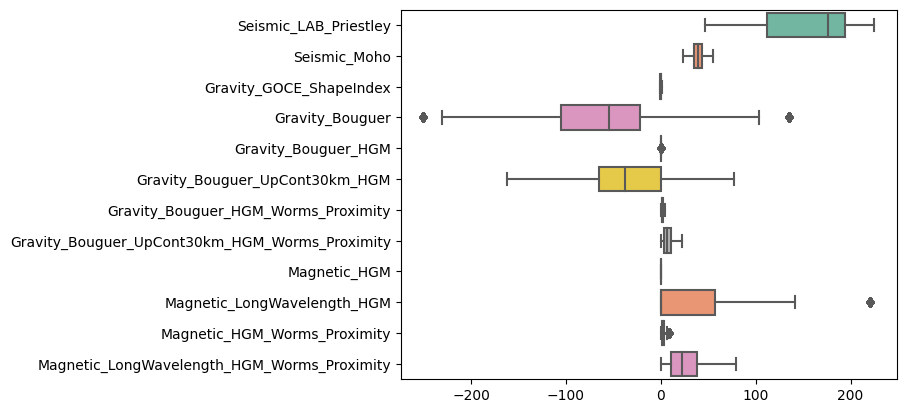

In [11]:
mvt_data = tukey_remove_outliers(mvt_data)
ax = sns.boxplot(data=mvt_data, orient="h", palette="Set2")

There are also many NaNs in the data, these can be "imputed" with the mean value.

In [12]:
print(mvt_data.isna().sum())

Seismic_LAB_Priestley                                  0
Seismic_Moho                                        1307
Gravity_GOCE_ShapeIndex                                0
Gravity_Bouguer                                    36401
Gravity_Bouguer_HGM                                36445
Gravity_Bouguer_UpCont30km_HGM                     36427
Gravity_Bouguer_HGM_Worms_Proximity                    0
Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity         0
Magnetic_HGM                                      136723
Magnetic_LongWavelength_HGM                       136922
Magnetic_HGM_Worms_Proximity                           0
Magnetic_LongWavelength_HGM_Worms_Proximity            0
dtype: int64


In [13]:
def impute_nans(df):
    # fills nan values with mean, for each column
    for col in df.columns:
        df[col].fillna(value=df[col].mean(), inplace=True)
    return df

In [14]:
mvt_data = impute_nans(mvt_data)
print(mvt_data.isna().sum())

Seismic_LAB_Priestley                             0
Seismic_Moho                                      0
Gravity_GOCE_ShapeIndex                           0
Gravity_Bouguer                                   0
Gravity_Bouguer_HGM                               0
Gravity_Bouguer_UpCont30km_HGM                    0
Gravity_Bouguer_HGM_Worms_Proximity               0
Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity    0
Magnetic_HGM                                      0
Magnetic_LongWavelength_HGM                       0
Magnetic_HGM_Worms_Proximity                      0
Magnetic_LongWavelength_HGM_Worms_Proximity       0
dtype: int64


Finally, it can be observed the above data is not "normalized", we should make features standard scores / z-scores

In [15]:
def normalize_df(df):
    # standardizes the data
    return (df-df.mean()) / df.std()

(note remaining outliers above were within the Tukey fences calculated over ALL the data)


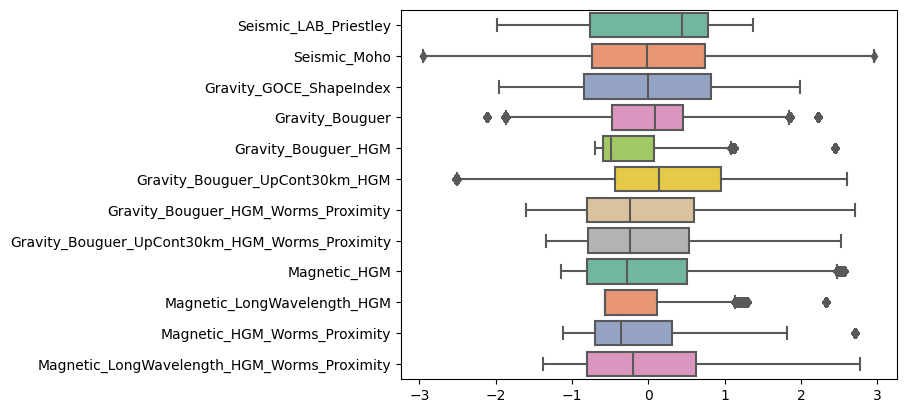

In [16]:
mvt_data = normalize_df(mvt_data)
ax = sns.boxplot(data=mvt_data, orient="h", palette="Set2")
print("(note remaining outliers above were within the Tukey fences calculated over ALL the data)")

Discretizes the continuous variables in 5 bins

In [20]:
mvt_data

,Seismic_LAB_Priestley,Seismic_Moho,Gravity_GOCE_ShapeIndex,Gravity_Bouguer,Gravity_Bouguer_HGM,Gravity_Bouguer_UpCont30km_HGM,Gravity_Bouguer_HGM_Worms_Proximity,Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity,Magnetic_HGM,Magnetic_LongWavelength_HGM,Magnetic_HGM_Worms_Proximity,Magnetic_LongWavelength_HGM_Worms_Proximity
0,"(0.595, 0.859]","(0.282, 0.933]","(-0.317, 0.263]","(-0.718, -0.0411]","(-0.7, -0.61]","(-2.524, -0.658]","(0.0482, 0.827]","(-1.3379999999999999, -0.885]","(0.766, 2.567]","(-0.56254166, -0.56254161]","(-0.156, 0.549]","(-1.3809999999999998, -0.924]"
1,"(0.595, 0.859]","(0.282, 0.933]","(-0.317, 0.263]","(-0.718, -0.0411]","(-0.7, -0.61]","(-2.524, -0.658]","(-0.897, -0.476]","(-1.3379999999999999, -0.885]","(0.766, 2.567]","(-0.56254166, -0.56254161]","(-0.748, -0.517]","(-1.3809999999999998, -0.924]"
2,"(0.595, 0.859]","(0.282, 0.933]","(-0.317, 0.263]","(-0.718, -0.0411]","(-0.7, -0.61]","(-2.524, -0.658]","(0.0482, 0.827]","(-1.3379999999999999, -0.885]","(0.766, 2.567]","(-0.56254166, -0.56254161]","(-0.156, 0.549]","(-1.3809999999999998, -0.924]"
3,"(0.595, 0.859]","(0.282, 0.933]","(-0.317, 0.263]","(-0.718, -0.0411]","(-0.7, -0.61]","(-2.524, -0.658]","(0.827, 2.701]","(-1.3379999999999999, -0.885]","(0.766, 2.567]","(-0.56254166, -0.56254161]","(0.549, 2.703]","(-1.3809999999999998, -0.924]"
4,"(0.595, 0.859]","(0.282, 0.933]","(-0.317, 0.263]","(-0.718, -0.0411]","(-0.7, -0.61]","(-2.524, -0.658]","(-0.476, 0.0482]","(-1.3379999999999999, -0.885]","(0.766, 2.567]","(-0.56254166, -0.56254161]","(0.549, 2.703]","(-1.3809999999999998, -0.924]"
...,...,...,...,...,...,...,...,...,...,...,...,...
5164965,"(-1.097, 0.125]","(0.282, 0.933]","(-1.9569999999999999, -1.027]","(-2.108, -0.718]","(0.43, 2.45]","(0.951, 2.604]","(-0.897, -0.476]","(0.776, 2.52]","(-1.144, -0.879]","(-0.56254152, 0.58634651]","(-0.748, -0.517]","(0.862, 2.776]"
5164966,"(-1.097, 0.125]","(-2.947, -0.883]","(-1.027, -0.317]","(-2.108, -0.718]","(0.43, 2.45]","(0.951, 2.604]","(0.0482, 0.827]","(-1.3379999999999999, -0.885]","(-0.53, 0.0]","(-0.56254152, 0.58634651]","(0.549, 2.703]","(-0.924, -0.458]"
5164967,"(-1.097, 0.125]","(-2.947, -0.883]","(-1.027, -0.317]","(-2.108, -0.718]","(0.43, 2.45]","(0.951, 2.604]","(0.827, 2.701]","(-0.467, 0.025]","(-0.53, 0.0]","(-0.56254152, 0.58634651]","(0.549, 2.703]","(-0.924, -0.458]"
5164968,"(-1.097, 0.125]","(-2.947, -0.883]","(-1.027, -0.317]","(-2.108, -0.718]","(0.43, 2.45]","(0.951, 2.604]","(-0.476, 0.0482]","(-0.467, 0.025]","(-0.879, -0.53]","(-0.56254152, 0.58634651]","(0.549, 2.703]","(-0.924, -0.458]"


In [17]:
nbins = 5
for col in baseline_cols:
    mvt_data[col] = pd.qcut(mvt_data[col], nbins)
mvt_data["target"] = mvt_labels['MVT_Deposit_wNeighbors']

KeyError: 'MVT_Deposit_wNeighbors'

WOE and IV computation from online

In [14]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        }) 
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    dset = dset.sort_values(by='WoE')
    return dset, iv

Computes WOE / IV for each variable

In [15]:
lst = []
IV_df = pd.DataFrame(columns=['Variable','IV'])
for col in mvt_data.columns:
    if col == 'DEFAULTER': continue
    else:
        df, iv = calculate_woe_iv(mvt_data, col, 'target')
               
    lst.append(df)
    IV_df = pd.concat([IV_df, pd.DataFrame([{"Variable" :col ,"IV" : iv,}])],ignore_index=True)

/home/adaruna/miniconda3/envs/ta3-baseline/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Merge the WOE data into the existig input datacube

In [16]:
# shows the overall IV for all variables on MVT deposits/occurences
print(f"Information Value Overview:\n{IV_df}\n\n\n")

# shows the WOE for all variables on MVT deposits/occurences
mvt_result = mvt_data
for i, col in enumerate(baseline_cols):
    col_data = lst[i]
    col_data = col_data.rename(columns={"Value":col,"WoE":f"{col}_WoE", "IV":f"{col}_IV"})
    mvt_result = pd.merge(mvt_result, col_data[[col,f"{col}_WoE",f"{col}_IV"]], on=col)

Information Value Overview:
                                          Variable        IV
0                            Seismic_LAB_Priestley  1.073537
1                                     Seismic_Moho  0.781432
2                          Gravity_GOCE_ShapeIndex  0.209594
3                                  Gravity_Bouguer  0.485995
4                              Gravity_Bouguer_HGM  0.332204
5                   Gravity_Bouguer_UpCont30km_HGM  0.551602
6              Gravity_Bouguer_HGM_Worms_Proximity  0.017943
7   Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity  0.109203
8                                     Magnetic_HGM  0.260378
9                      Magnetic_LongWavelength_HGM  0.558662
10                    Magnetic_HGM_Worms_Proximity  0.037192
11     Magnetic_LongWavelength_HGM_Worms_Proximity  0.133167
12                                          target  0.000000





,Seismic_LAB_Priestley,Seismic_Moho,Gravity_GOCE_ShapeIndex,Gravity_Bouguer,Gravity_Bouguer_HGM,Gravity_Bouguer_UpCont30km_HGM,Gravity_Bouguer_HGM_Worms_Proximity,Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity,Magnetic_HGM,Magnetic_LongWavelength_HGM,...,Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity_WoE,Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity_IV,Magnetic_HGM_WoE,Magnetic_HGM_IV,Magnetic_LongWavelength_HGM_WoE,Magnetic_LongWavelength_HGM_IV,Magnetic_HGM_Worms_Proximity_WoE,Magnetic_HGM_Worms_Proximity_IV,Magnetic_LongWavelength_HGM_Worms_Proximity_WoE,Magnetic_LongWavelength_HGM_Worms_Proximity_IV
0,"(0.595, 0.859]","(0.282, 0.933]","(-0.317, 0.263]","(-0.718, -0.0411]","(-0.7, -0.61]","(-2.524, -0.658]","(0.0482, 0.827]","(-1.3379999999999999, -0.885]","(0.766, 2.567]","(-0.56254166, -0.56254161]",...,-0.328558,0.025556,-0.549346,0.080414,-0.661177,0.123868,-0.177287,0.006877,-0.4202,0.043882
1,"(0.595, 0.859]","(0.282, 0.933]","(-0.317, 0.263]","(-0.718, -0.0411]","(-0.7, -0.61]","(-2.524, -0.658]","(0.0482, 0.827]","(-1.3379999999999999, -0.885]","(0.766, 2.567]","(-0.56254166, -0.56254161]",...,-0.328558,0.025556,-0.549346,0.080414,-0.661177,0.123868,-0.177287,0.006877,-0.4202,0.043882
2,"(0.595, 0.859]","(0.282, 0.933]","(-0.317, 0.263]","(-0.718, -0.0411]","(-0.7, -0.61]","(-2.524, -0.658]","(0.0482, 0.827]","(-1.3379999999999999, -0.885]","(0.766, 2.567]","(-0.56254166, -0.56254161]",...,-0.328558,0.025556,-0.549346,0.080414,-0.661177,0.123868,-0.177287,0.006877,-0.4202,0.043882
3,"(0.125, 0.595]","(0.933, 2.96]","(0.263, 1.022]","(-0.718, -0.0411]","(-0.7, -0.61]","(-2.524, -0.658]","(0.0482, 0.827]","(-1.3379999999999999, -0.885]","(0.766, 2.567]","(-0.56254166, -0.56254161]",...,-0.328558,0.025556,-0.549346,0.080414,-0.661177,0.123868,-0.177287,0.006877,-0.4202,0.043882
4,"(-1.097, 0.125]","(0.282, 0.933]","(-0.317, 0.263]","(-2.108, -0.718]","(-0.7, -0.61]","(-2.524, -0.658]","(0.0482, 0.827]","(-1.3379999999999999, -0.885]","(0.766, 2.567]","(-0.56254166, -0.56254161]",...,-0.328558,0.025556,-0.549346,0.080414,-0.661177,0.123868,-0.177287,0.006877,-0.4202,0.043882


In [17]:
def get_spatial_cross_val_idx(df, k=5):
    # select only the deposit/occurence/neighbor present samples
    target_df = df.loc[df["target"] == True,"Latitude_EPSG4326"]
    # sort the latitudes
    target_df = target_df.sort_values(ignore_index=True)
    # bin the latitudes into sizes of 1-3 samples per bin
    nbins = ceil(len(target_df) / 3.0)
    _, bins = pd.qcut(target_df, nbins, retbins=True)
    bins[0] = -float("inf")
    bins[-1] = float("inf")
    bins = pd.IntervalIndex.from_breaks(bins)
    # group the bins into k+1 groups (folds) - +1 is for test set
    bins_df = pd.DataFrame({"Latitude_EPSG4326": bins})
    bins_df["group"] = np.tile(np.arange(k+1), (ceil(nbins / k+1),))[:nbins]
    # assign all data to a k+1 group using the existing bin / group assignments
    df["Latitude_EPSG4326"] = pd.cut(df["Latitude_EPSG4326"], bins)
    df = pd.merge(df, bins_df, on="Latitude_EPSG4326")
    # split into train / test data
    test_df = df[df["group"] == k]
    train_df = df[df["group"] < k]
    # generate a group k-fold sampling
    group_kfold = GroupKFold(n_splits=k)
    train_idx = group_kfold.split(train_df, train_df["target"], train_df["group"])
    return test_df, train_df, train_idx

Adds the latitudes to the datacube to make train, validation, and test splits

In [24]:
mvt_result["Latitude_EPSG4326"] = data["Latitude_EPSG4326"]
te_df, tr_df, splits = get_spatial_cross_val_idx(mvt_result)

Shows the cross validation splits (train / val); test split is held out of cross validation

In [25]:
for i, (train_index, val_index) in enumerate(splits):
    print(f"Fold {i}:")
    print(f"  Train: groups={np.unique(tr_df.iloc[train_index.tolist()]['group'].tolist())}")
    print(f"  Val: groups={np.unique(tr_df.iloc[val_index.tolist()]['group'].tolist())}")

Fold 0:
  Train: groups=[1 2 3 4]
  Val: groups=[0]
Fold 1:
  Train: groups=[0 1 3 4]
  Val: groups=[2]
Fold 2:
  Train: groups=[0 1 2 3]
  Val: groups=[4]
Fold 3:
  Train: groups=[0 2 3 4]
  Val: groups=[1]
Fold 4:
  Train: groups=[0 1 2 4]
  Val: groups=[3]
